# 5. Regression with XGBoost

**Purpose:** Build a `scikit-learn` `pipeline` to train an XGBoost regression model to predict an organic molecule's boiling point from only plain-text SMILES chemical structure codes.

**Contents:** The notebook contains:
* A preprocessing pipeline (`pre_processor`) to convert plain-text SMILES codes to previously determined features using the [RDKit library](https://www.rdkit.org/docs/Overview.html).
* A regression pipeline (`bp_pipeline`) to train an XGBoost regressor.
* An evaluation of whether or not upsampling aromatic molecules within the data set provides improved predictive performance.
* Hyperparameter optimization.

**Conclusions:** Key conclusions & outputs are:
* The fully trained model and preprocessor are exported as a single `scikit-learn` pipeline (`deployment/model/full_pipe.pkl`).
* Upsampling aromatic molecules within the original data set gives no meaningful improvement in overall accuracy vs. in the validation set. There is no clear advantage even when evaluating only aromatic molecules.
* Of the 1316 elements in the validation set, this model gives predictions that are within +/- 10% of the measured boiling point for 1313 of them (> 99 %). Further, 90% of the validation set predictions fall within 9.7 K of the measured value.

*Note*: This notebook relies on interactive Plotly graphs in several locations. They may not render properly in GitHub's web interface.

## Import the necessary modules & data.

In [1]:
# Import the training & validation sets.
import pandas as pd
## Import the remaining data
for dataset in ["x_train", "y_train", "x_val", "y_val"]:
    exec("{} = pd.read_csv('data/{}-CHNO.csv')".format(dataset, dataset))

In [2]:
x_train_smiles = x_train
x_val_smiles = x_val

## Preprocess the data.

First, we'll take care of pre-processing the data. That means:
* Converting the SMILES code to the three numeric features: molecular weight, branching fraction, and hydrogen bond donors. Dropping the series containing the SMILES code. This is all done by the SmilesTransformer class.
* Imputing any missing values.

*A note on good practice:* Ideally, I would like to incorporate the SMILES code transformer directly into the pre-processing pipeline alongside the imputer. I tried that first, and encountered problems when exporting the model for deployment. Unfortunately, the SMILES transformer relies on several of the `rdkit` module's functions that employ lambda functions. These cannot readily be pickled. If the SMILES transformer is included in the pre-processor pipeline, the entire pipeline also cannot be picked. For production, we'll therefore need a SMILES transformer class that is imported separately from the pre-processor and trained model (as a pickle).

#### **Pre-Processing: Convert SMILES codes to numeric data.**
We'll parse the SMILES code into the features of interest. A transformer class is defined below:

In [3]:
# We'll need access to portions of the RDKit module to handle SMILES interpretation.
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors
import numpy as np

class SmilesTransformer():
    
    def __init__(self):

        # The two features in this dict are useful as stand-alone features that
        # do not rely upon SMARTS-based substructure searching
        self.mol_features = {"h_bond_donors" : Lipinski.NumHDonors,
                            "mol_wt" : Descriptors.ExactMolWt,
                            "rings_aromatic" : Lipinski.NumAromaticRings}
    
    
    #Helper function to determine features based on SMARTS substructure codes.
    # Currently that is only the branching fraction (i.e.: the fraction of
    # all carbon atoms that are secondary or tertiary and aliphatic)
    # Called by the instance's _transform_ function.
    def substructure_search(self, row):
        self.smiles_code = row["SMILES"]
        self.molecule = Chem.MolFromSmiles(self.smiles_code)

        # If the SMILES code was properly interpreted, compute the descriptors of interest.
        # If not, populate the columns with NaN instead.
        if self.molecule is not None:
        
            # Use SMARTS substructure codes to count the total number of carbon atoms
            # & the total number of branched aliphatic carbons (i.e.: tertiary or quaternary carbon atoms)
            self.carbon_count = len(self.molecule.GetSubstructMatches(Chem.MolFromSmarts("[#6]")))
            self.branch_carbon_count = len(self.molecule.GetSubstructMatches(Chem.MolFromSmarts("[$([C;H1,H0]([#6])([#6])([#6]))]")))
       
            # Prevent division by zero.
            if self.carbon_count !=0:
                branch_frac = self.branch_carbon_count / self.carbon_count
                row["branch_fraction"] = branch_frac
            else:
                row["branch_fraction"] = np.nan
        
        else:
           row["branch_fraction"] = np.nan
        
        return row
    
    
    # Function to determine other properties that are _not_ based on SMARTS substructure codes.
    # Called by the instance's _transform_ function.
    def get_other_properties(self, smiles_code, property):
        self.smiles_code = smiles_code
        self.molecule = Chem.MolFromSmiles(self.smiles_code)
        self.property = property
        
        # If the SMILES code was properly interpreted, compute the descriptors of interest.
        # If not, populate the columns with NaN instead.
        if self.molecule is not None:
            return self.mol_features[self.property](self.molecule)
        else:
            return np.nan

        
    # When the class instance's tranform function is executed, parse the SMILES codes.
    def transform(self, X):
        
        # Invoke the function for SMARTS-based substructure searching
        X = X.apply(self.substructure_search, axis = 1)
        
        # Call the function for determining other structural features
        for property in self.mol_features.keys():
            exec("X.loc[:, '{}'] = X['SMILES'].apply(self.get_other_properties, args = ('{}',))".format(property, property))
        
        X = X.drop("SMILES", axis = 1)
        # Dropping a column raises a warning downstream unless the data is restructured as a contiguous array.
        X = np.ascontiguousarray(X)
        
        # Returned the transformed data as a numpy array.
        return X

Next, instantiate the class and transform the SMILES codes to an array of structural data. Inspect the array.

In [4]:
smilestrans = SmilesTransformer()

In [5]:
x_train = smilestrans.transform(x_train_smiles)
x_train

array([[5.55555556e-02, 0.00000000e+00, 2.52281701e+02, 0.00000000e+00],
       [9.09090909e-02, 0.00000000e+00, 1.48125201e+02, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.34109550e+02, 1.00000000e+00],
       ...,
       [7.14285714e-02, 1.00000000e+00, 2.14229666e+02, 0.00000000e+00],
       [2.50000000e-01, 0.00000000e+00, 1.70203451e+02, 0.00000000e+00],
       [1.42857143e-01, 0.00000000e+00, 2.28208930e+02, 0.00000000e+00]])

In [6]:
train_df = pd.DataFrame(x_train, columns = ["branch_frac", "h_bond_donors", "molecular_wt", "aromatic_rings"])

#### **Pre-Processing: Complete the pre-processing portion of the `pipeline`.**
Impute any null values in the feature set and Z-scale the data.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from numpy import log10

Instantiate a column transformer to log-transform the molecular weight data. Other column data should be passed forward through the pipeline:

In [8]:
log_transformer = FunctionTransformer(log10)

In [9]:
col_transformer = ColumnTransformer([
                        ("mol_wt_transformer", log_transformer, [2])
                        ],
                    remainder = "passthrough")

The complete pre-processing pipeline needs to transform the molecular weight data & impute any missing values:

In [10]:
pre_processor = Pipeline(steps = [
                                    ("imputer", SimpleImputer(strategy = "median")),
                                    ("column_transformer", col_transformer)
                                 ])

The `pre_processor` pipeline is complete. It accepts a `numpy` array of structural features, returning an imputed and transformed array with shape (, 3). Each row in the returned array represents one chemical, and the columns represent the **fraction of all carbon atoms that are aliphatic branches (tertiary or quaternary)**, the **number of hydrogen-bonding donors**,  the **molecular weight**, and the **number of aromatic rings** (in that order).

#### **Add a Regressor to the pipeline.**

In [11]:
# Import the necessary modules.
from xgboost import XGBRegressor

In [12]:
# Assemble the completed pipeline.
bp_pipeline = Pipeline(steps = [
                                ("pre-processing", pre_processor),
                                ("regression", XGBRegressor())
                                ])

The pipeline is complete!

## Train a very basic model.
Now that our `bp_pipeline` is fully established, we just need to import the remaining data and test out an unoptimized model fitting to confirm that we're on the right track.

In [13]:
bp_pipeline.fit(x_train, y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('column_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('mol_wt_transformer',
                                                                   FunctionTransformer(func=<ufunc 'log10'>),
                                                                   [2])]))])),
                ('regression',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsa..., gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing

In [14]:
x_val = smilestrans.transform(x_val_smiles)

In [15]:
bp_pipeline.score(x_val, y_val)

0.9734105996334608

Awesome! It loooks like even with this super basic model, our boiling point predictions are pretty decent. Let's look at the quality of the predictions a little more carefully.

In [16]:
preds_array = bp_pipeline.predict(x_val)

In [17]:
preds = pd.DataFrame(preds_array)
preds.columns = ["Predicted_BP_K"]
preds["Measured_BP_K"] = y_val
preds["SMILES_code"] = x_val_smiles

In [18]:
import plotly.express as px

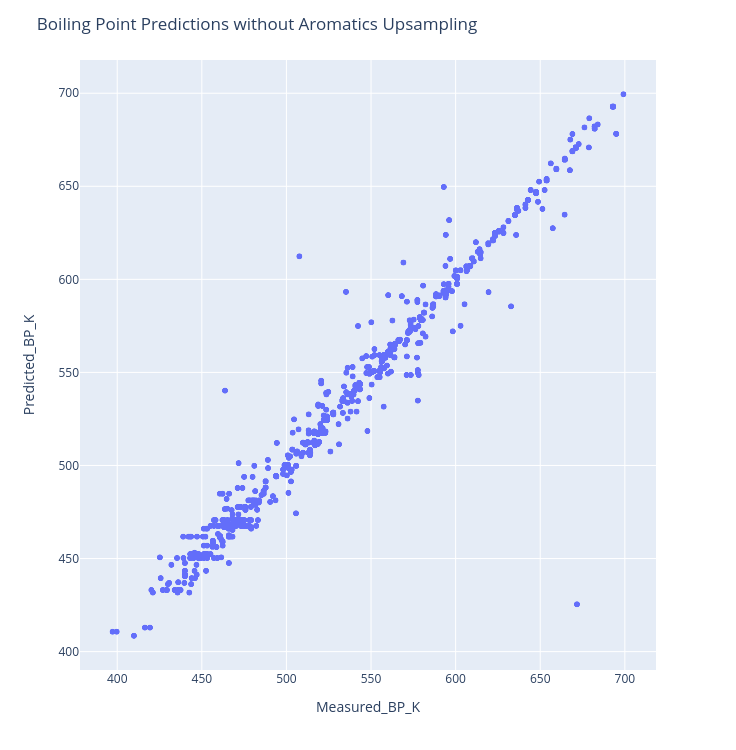

In [19]:
parity_plot = px.scatter(preds, x = "Measured_BP_K", y = "Predicted_BP_K", hover_name = "SMILES_code")
parity_plot.update_layout(width = 750, height = 750, title = "Boiling Point Predictions without Aromatics Upsampling")
parity_plot.show()

This parity plot shows fairly good agreement between the predicted & measured boiling points. Several of the poorest predictions seem to be aromatic molecules. Having succeeded in this simple proof-of-concept, let's determine if the predictions can be improved by upsampling the under-represented aromatic molecules.

## Effect of upsampling.

During the EDA phase, the aromatics data was upsampled to account for a relatively small number of aromatics in the data set. Let's see how that impacts the quality of our predictions.

Read the data sets with upsampled aromatics data:

In [20]:
x_train_upsamp_smiles = pd.read_csv("data/x_train-CHNO_upsampled.csv")

In [21]:
x_train_upsamp = smilestrans.transform(x_train_upsamp_smiles)
x_train_upsamp

array([[5.55555556e-02, 0.00000000e+00, 2.52281701e+02, 0.00000000e+00],
       [9.09090909e-02, 0.00000000e+00, 1.48125201e+02, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.34109550e+02, 1.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.34140851e+02, 3.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.21084064e+02, 3.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.06109550e+02, 3.00000000e+00]])

In [22]:
y_train_upsamp = pd.read_csv("data/y_train-CHNO_upsampled.csv")
y_train_upsamp

BP
0     578.81
1     473.15
2     459.98
3     595.82
4     511.26
...      ...
8636  613.20
8637  633.15
8638  679.81
8639  633.20
8640  648.29

[8641 rows x 1 columns]

Re-fit the pipeline, this time using the upsampled data sets:

In [23]:
bp_pipeline.fit(x_train_upsamp, y_train_upsamp)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('column_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('mol_wt_transformer',
                                                                   FunctionTransformer(func=<ufunc 'log10'>),
                                                                   [2])]))])),
                ('regression',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsa..., gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing

In [24]:
bp_pipeline.score(x_val, y_val)

0.9703683121500766

Generate predictions from the validation set & prepare another parity plot:

In [25]:
preds_array_upsampled = bp_pipeline.predict(x_val)

In [26]:
preds_up = pd.DataFrame(preds_array_upsampled)
preds_up.columns = ["Predicted_BP_K"]
preds_up["Measured_BP_K"] = y_val
preds_up["SMILES_code"] = x_val_smiles

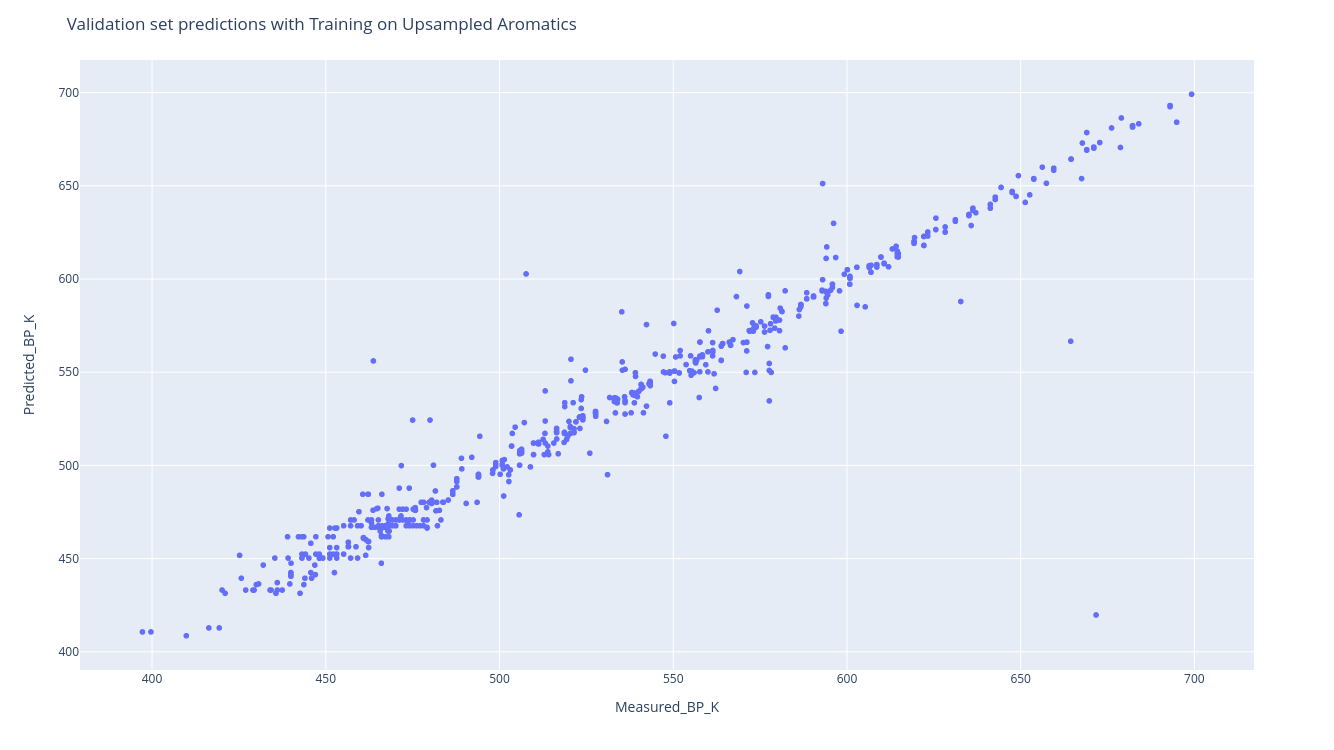

In [27]:
parity_plot_up = px.scatter(preds_up, x = "Measured_BP_K", y = "Predicted_BP_K", hover_name = "SMILES_code")
parity_plot_up.update_layout(width = 750, height = 750, title = "Validation set predictions with Training on Upsampled Aromatics")
parity_plot_up.show()

Merge the upsampled & non-upsampled predictions into a single dataframe to allow for comparisons:

In [28]:
preds["Aromatics_upsampled"] = "No"
preds_up["Aromatics_upsampled"] = "Yes"

In [29]:
preds["Number_arom_rings"] = x_val[0:,3]
preds_up["Number_arom_rings"] = x_val[0:,3]

In [30]:
preds_up = pd.concat([preds, preds_up])
preds_up

Predicted_BP_K  Measured_BP_K                 SMILES_code  \
0         641.659546         648.67    CCCCCCCCCCC1CCCc2ccccc12   
1         590.256104         594.04     CCCC(C)CCCCCCC(C)C(O)=O   
2         504.141907         501.39           CCCCCCCCC(=O)OC=C   
3         592.749817         594.43        CCCCCCCC(C)C=CC(O)=O   
4         450.275818         445.15         CCCC(C(C)C)C(C)(C)C   
...              ...            ...                         ...   
1311      634.061951         635.10       OC(=O)CCCCCCCCCCCCC=C   
1312      475.958557         475.75       CCC(C)C(=O)OC(C)(C)CC   
1313      692.453247         692.99  CCCCCCCCCC=CCCCCCCCCC(O)=O   
1314      543.076477         543.34     CCCCC(=O)OC(C)CCC(C)CCC   
1315      543.410889         540.75        CCCCCCCCC(C)C(C)C#CC   

     Aromatics_upsampled  Number_arom_rings  
0                     No                1.0  
1                     No                0.0  
2                     No                0.0  
3                     No                0.0  
4                     No                0.0  
...                  ...                ...  
1311                 Yes                0.0  
1312                 Yes                0.0  
1313                 Yes                0.0  
1314                 Yes                0.0  
1315                 Yes                0.0  

[2632 rows x 5 columns]

Calculate absolute errors (in Kelvin) and relative absolute errors (in percents) for each prediction. Create a box plot so that we can determine whether or not the upsampled training set results in better predictions for aromatic molecules:

In [31]:
preds_up["AbsoluteErr_K"] = abs(preds_up["Predicted_BP_K"] - preds_up["Measured_BP_K"])
preds_up["RelativeErr_%"] = preds_up["AbsoluteErr_K"] / preds_up["Measured_BP_K"] * 100

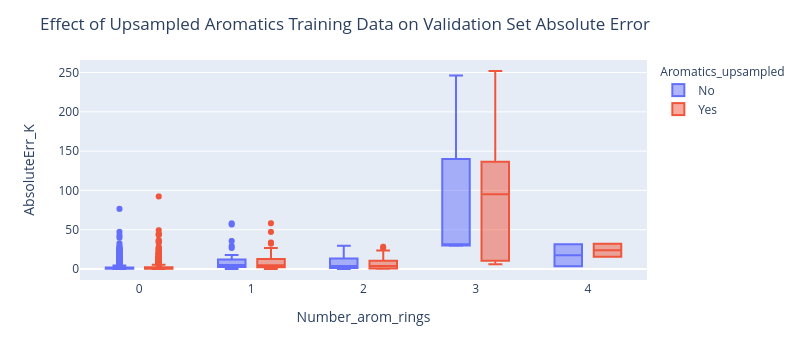

In [32]:
box_abs_err = px.box(preds_up, x = "Number_arom_rings", y = "AbsoluteErr_K", color = "Aromatics_upsampled")
box_abs_err.update_layout(title = "Effect of Upsampled Aromatics Training Data on Validation Set Absolute Error")
box_abs_err.show()

Upsampling the aromatics data has resulted in a very modest improvement in predictions for mono- and di-aromatics, but at the cost of slightly poorer predictions for non-aromatics and tetra-aromatics. Predictions for tri-aromatics are markedly worse, potentially due to under-representation in the upsampled data set.

Because upsampling does not result in a clear benefit for all sizes of aromatic molecules, let's default to examining the overall score for the validation set: 0.970 when upsampling is used vs. 0.973 without upsampling the aromatics data. With that in mind, we will **proceed without upsampling the aromatics data.**

## Elementary hyperparameter optimization.

With a workable model in place, let's conduct a survey of regression hyperparameters in an effort to further improve the predictions.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

Read the pipeline's architecture to learn the correct parameter names:

In [34]:
bp_pipeline.get_params()

{'memory': None,
 'steps': [('pre-processing',
   Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                   ('column_transformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('mol_wt_transformer',
                                                     FunctionTransformer(func=<ufunc 'log10'>),
                                                     [2])]))])),
  ('regression',
   XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       

Define the parameters to include in the survey:
* Learning rate
* Maximum number of elementary learners to use
* Maximum allowable tree depth
* Minimum child weight

In [35]:
grid_params = {"regression__learning_rate" : [0.3, 0.4],
               "regression__n_estimators" : [100, 500, 1000],
               "regression__max_depth" : [3, 4, 5],
               "regression__min_child_weight" : [1, 2, 3]
              }

Conduct the grid search:

In [36]:
gs = GridSearchCV(bp_pipeline,
                  grid_params,
                  scoring = "neg_mean_squared_error",
                  verbose = 0)

In [37]:
gs.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pre-processing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='median')),
                                                        ('column_transformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('mol_wt_transformer',
                                                                                          FunctionTransformer(func=<ufunc 'log10'>),
                                                                                          [2])]))])),
                                       ('regression',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample

Examine the grid search results as a DataFrame:

In [38]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regression__learning_rate', 'param_regression__max_depth',
       'param_regression__min_child_weight', 'param_regression__n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [39]:
cv_results = cv_results.drop(["mean_score_time", "std_score_time", "split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score", "split4_test_score", "params"], axis = 1)

In [40]:
cv_results.sort_values("rank_test_score")

mean_fit_time  std_fit_time param_regression__learning_rate  \
18       0.110875      0.011519                             0.3   
19       0.509073      0.010763                             0.3   
51       0.103737      0.005689                             0.4   
20       1.008241      0.032709                             0.3   
52       0.451941      0.017381                             0.4   
45       0.786485      1.220140                             0.4   
46       1.416388      1.798102                             0.4   
10       0.400733      0.008287                             0.3   
47       1.804097      1.050419                             0.4   
53       1.767869      1.082890                             0.4   
11       0.781435      0.043745                             0.3   
26       0.970902      0.018815                             0.3   
49       0.515189      0.031446                             0.4   
25       0.476964      0.013941                             0.3   
50       0.995219      0.021407                             0.4   
14       0.801856      0.008844                             0.3   
13       0.410515      0.023398                             0.3   
22       0.492230      0.014433                             0.3   
17       0.794387      0.017074                             0.3   
44       1.300805      0.606692                             0.4   
23       0.987301      0.025860                             0.3   
2        0.645056      0.010735                             0.3   
24       0.109468      0.011831                             0.3   
16       0.416526      0.015523                             0.3   
32       0.648055      0.030211                             0.4   
43       0.400366      0.008088                             0.4   
41       1.223761      0.223341                             0.4   
48       0.113276      0.010118                             0.4   
40       0.665419      0.191406                             0.4   
1        0.331080      0.012247                             0.3   
37       0.401765      0.010608                             0.4   
21       0.107736      0.010126                             0.3   
28       0.320984      0.010224                             0.4   
29       0.639303      0.006704                             0.4   
38       2.184777      1.208529                             0.4   
31       0.313781      0.010326                             0.4   
5        0.669731      0.040134                             0.3   
35       0.630545      0.012113                             0.4   
9        0.093299      0.010320                             0.3   
34       0.318003      0.010301                             0.4   
12       0.087542      0.008464                             0.3   
15       0.092360      0.007012                             0.3   
42       0.166121      0.066789                             0.4   
39       0.155504      0.084943                             0.4   
8        0.628837      0.017547                             0.3   
36       0.091744      0.011213                             0.4   
4        0.315864      0.009469                             0.3   
7        0.328312      0.014104                             0.3   
30       0.078712      0.010700                             0.4   
33       0.074660      0.009723                             0.4   
27       0.074248      0.007281                             0.4   
0        0.374743      0.395048                             0.3   
6        0.072670      0.010379                             0.3   
3        0.076179      0.007681                             0.3   

   param_regression__max_depth param_regression__min_child_weight  \
18                           5                                  1   
19                           5                                  1   
51                           5                                  3   
20                           5            

In [41]:
gs.best_estimator_.steps

[('pre-processing',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('column_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('mol_wt_transformer',
                                                    FunctionTransformer(func=<ufunc 'log10'>),
                                                    [2])]))])),
 ('regression',
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.3, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=

With a first-pass optimization complete, we're ready to begin using the model for predictions.

## Generate & Visualize the predictions

First, generate predictions from the validation set and convert them to a readable DataFrame.

In [42]:
preds_array = gs.best_estimator_.predict(x_val)

In [43]:
preds = pd.DataFrame(preds_array)
preds.columns = ["Predicted_BP_K"]
preds["Measured_BP_K"] = y_val
preds["SMILES_code"] = x_val_smiles
preds

Predicted_BP_K  Measured_BP_K                 SMILES_code
0         633.663635         648.67    CCCCCCCCCCC1CCCc2ccccc12
1         589.548340         594.04     CCCC(C)CCCCCCC(C)C(O)=O
2         508.106079         501.39           CCCCCCCCC(=O)OC=C
3         592.031555         594.43        CCCCCCCC(C)C=CC(O)=O
4         450.135895         445.15         CCCC(C(C)C)C(C)(C)C
...              ...            ...                         ...
1311      633.490967         635.10       OC(=O)CCCCCCCCCCCCC=C
1312      479.818329         475.75       CCC(C)C(=O)OC(C)(C)CC
1313      693.440552         692.99  CCCCCCCCCC=CCCCCCCCCC(O)=O
1314      543.563110         543.34     CCCCC(=O)OC(C)CCC(C)CCC
1315      544.426758         540.75        CCCCCCCCC(C)C(C)C#CC

[1316 rows x 3 columns]

Generate another parity plot using the validation data.

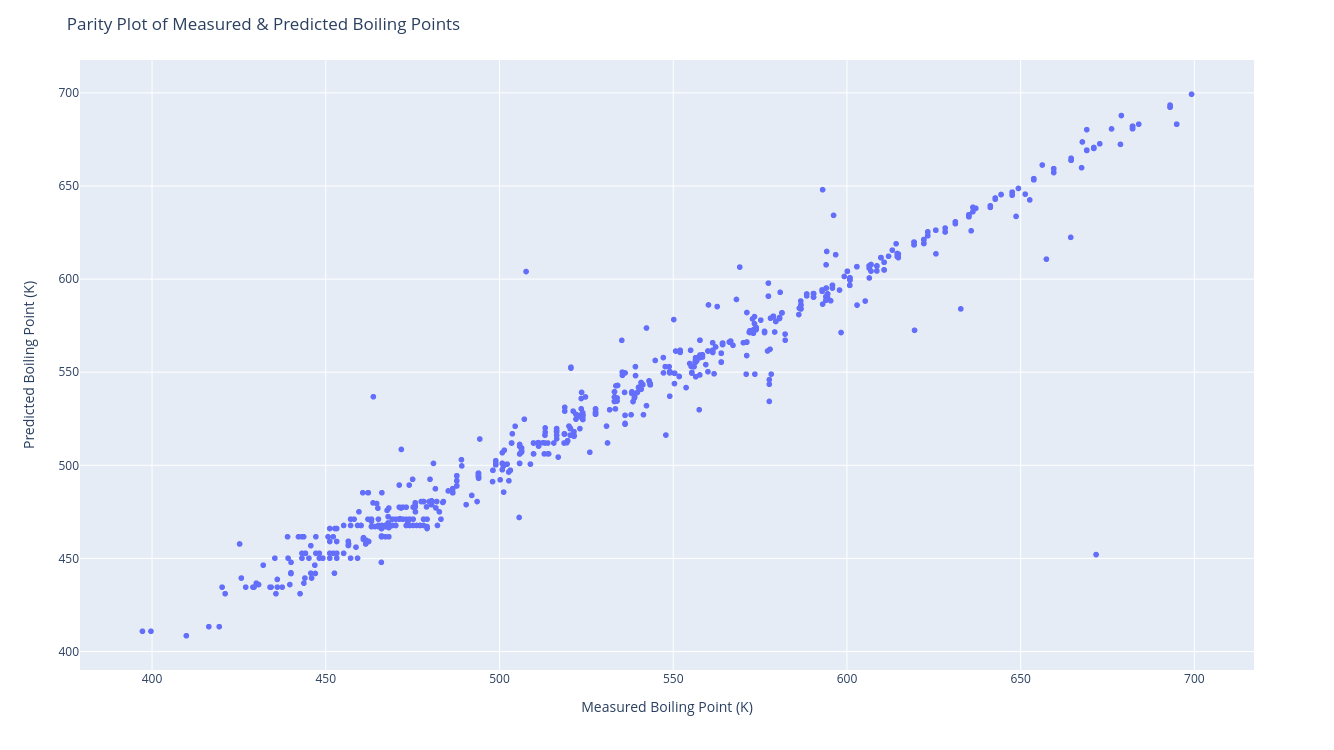

In [44]:
parity_plot = px.scatter(preds, x = "Measured_BP_K", y = "Predicted_BP_K", hover_name = "SMILES_code")
parity_plot.update_layout(width = 750,
                          height = 750,
                          xaxis_title = "Measured Boiling Point (K)",
                          yaxis_title = "Predicted Boiling Point (K)",
                          title_text = "Parity Plot of Measured & Predicted Boiling Points")
parity_plot.show()

This is a nice plot. Let's export it for future use when the model is deployed:

In [45]:
parity_plot.write_html("deployment/static/validation-data/parity-plot.html")

Determine error and percent relative error for the predictions.

In [46]:
preds["error_K"] = preds["Predicted_BP_K"] - preds["Measured_BP_K"]
preds["abs_error_K"] = abs(preds["error_K"])
preds["error_percent"] = preds["error_K"] / preds["Measured_BP_K"] * 100
preds["abs_error_percent"] = abs(preds["error_percent"])

In [47]:
# How many of the predictions are within +/- 10% of the measured values?
preds[preds["abs_error_percent"] >= 10].sort_values("abs_error_percent")

Predicted_BP_K  Measured_BP_K                        SMILES_code  \
561       536.815674         463.70           CC[NH+](CC)CC[NH+](CC)CC   
1047      604.054565         507.65  Cc1ccc2cc3c(CCc4ccccc34)c5CCc1c25   
1049      452.060120         671.70   O=C1OC(=O)c2cc3C(=O)OC(=O)c3cc12   

         error_K  abs_error_K  error_percent  abs_error_percent  
561    73.115674    73.115674      15.767883          15.767883  
1047   96.404565    96.404565      18.990361          18.990361  
1049 -219.639880   219.639880     -32.699104          32.699104

In [48]:
# What is the error range for 90% of predictions? For 95%?
preds["abs_error_K"].quantile(0.9), preds["abs_error_K"].quantile(0.95)

(9.666790771484386, 14.460589599609364)

Of the 1316 elements in the validation set, this model gives predictions that are within +/- 10% of the measured value for 1313 of them (> 99 %). Further, 90% of the validation set predictions fall within 9.7 K of the measured value, and 95% fall within 14.5 K.

All that's left is to export the model so that it can be deployed.

## Export the model

In [49]:
from joblib import dump, load

In [50]:
gs.best_estimator_.steps

[('pre-processing',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('column_transformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('mol_wt_transformer',
                                                    FunctionTransformer(func=<ufunc 'log10'>),
                                                    [2])]))])),
 ('regression',
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.3, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=

In [51]:
dump(gs.best_estimator_, "deployment/model/full_pipe.pkl")

['deployment/model/full_pipe.pkl']

Make sure the loaded model gives the same predictions as the original model:

In [52]:
loaded_pipe = load("deployment/model/full_pipe.pkl")

In [53]:
test_preds_array = loaded_pipe.predict(x_val)

In [54]:
pd.DataFrame(test_preds_array == preds_array).describe()

0
count   1316
unique     1
top     True
freq    1316

Great. The loaded model gives the same predictions on the validation set as the original model; everything was exported correctly.

We're now ready to build the frontend for predictions.